In [32]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import models
import torch.optim as optim
from torchvision import datasets, models
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import nbconvert
import os
from glob import glob
import random
import warnings
import pickle
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from scipy import ndimage
import numpy as np
import gzip
import nibabel as nib
import segmentation_models_pytorch as smp
import albumentations as albu
import cv2
from PIL import Image
import imageio
import sklearn
import shutil
import time
import os
import math
import copy

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [1]:
# For importing zipped data *COMPLETE*
import zipfile
with zipfile.ZipFile('/home/bhr2111/covidproject/chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/home/bhr2111/covidproject/data')

### To Do

* Load cov neg data and separate into one big folder, match number of pos for now --> done, with separate folders for now
* Create datasets and load --> done
* Construct and edit VGG pretrained model

### Moving Data to proper train, validate, test folders -COMPLETE-
Goal: Split negative and positive datasets into 6:2:2 datasplit and put into folders

1. Get list of all files in each directory (positive and negative)

2. Shuffle list randomly

3. Select first ~60% and shutil to train

4. Select next 20% for train and same for val


In [41]:
# For covid positive set *COMPLETE*
data_dir = '/home/bhr2111/covidproject/data/'
basepath = os.path.join(data_dir,'positive/')
targetbasepath = '/home/bhr2111/covidproject/data/'
imnames = [f for f in os.listdir(basepath) if f[-3:] == "png"]
numims = len(imnames)
print("Number of images in this dataset:",numims)

# Randomize list of images to ensure randomness in train, test, valid split
randomized = random.sample(imnames,len(imnames))

train_split = .6
valid_split = .2
test_split = .2

num_train = math.ceil(train_split*numims)
num_valid = math.floor(valid_split*numims)
num_test = math.floor(test_split*numims)
print(f"Datasplit: Train: {num_train}, Validate: {num_valid}, Test: {num_test}")

for idx,image in enumerate(imnames):
    if idx <= 85: # train
        shutil.move(basepath+image, targetbasepath+'train/'+image)
    elif 86 <= idx < 114: # valid
        shutil.move(basepath+image, targetbasepath+'val/'+image)
    else: # test
        shutil.move(basepath+image, targetbasepath+'test/'+image)

Number of images in this dataset: 142
Datasplit: Train: 86, Validate: 28, Test: 28


In [44]:
# For covid negative set *COMPLETE*
data_dir = '/home/bhr2111/covidproject/data/'
basepath = os.path.join(data_dir,'negative/')
targetbasepath = '/home/bhr2111/covidproject/data/'
imnames = [f for f in os.listdir(basepath) if f[-4:] == "jpeg"]
numims = len(imnames)
print("Number of images in this dataset:",numims)

# Randomize list of images to ensure randomness in train, test, valid split
randomized = random.sample(imnames,len(imnames))

train_split = .6
valid_split = .2
test_split = .2

num_train = math.ceil(train_split*numims)
num_valid = math.floor(valid_split*numims)
num_test = math.floor(test_split*numims)
print(f"Datasplit: Train: {num_train}, Validate: {num_valid}, Test: {num_test}")

for idx,image in enumerate(imnames):
    if idx <= 85: # train
        shutil.move(basepath+image, targetbasepath+'train/negative/'+image)
    elif 86 <= idx < 114: # valid
        shutil.move(basepath+image, targetbasepath+'val/negative/'+image)
    else: # test
        shutil.move(basepath+image, targetbasepath+'test/negative/'+image)

Number of images in this dataset: 142
Datasplit: Train: 86, Validate: 28, Test: 28


In [ ]:
# I had an issue with .ipynb checkpoint directories being hidden within my data directories, only use this cell if you have this issue
testdir = '/home/bhr2111/covidproject/data/val/'
[f for f in os.listdir(testdir) if f == '.ipynb_checkpoints']
os.rmdir('/home/bhr2111/covidproject/data/val/.ipynb_checkpoints')

In [79]:
data_dir = '/home/bhr2111/covidproject/data/'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 172 images under train
Loaded 56 images under val
Loaded 56 images under test
Classes: 
['negative', 'positive']


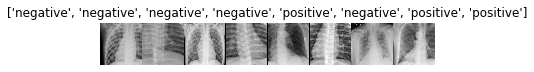

In [80]:
# Example images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [81]:
# Visualizer for model performance during training
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [83]:
# Model evaluation function
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data[0]
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [84]:
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth")) #issue?
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers (transfer learning)
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

FileNotFoundError: [Errno 2] No such file or directory: '../input/vgg16bn/vgg16_bn.pth'